In [1]:
import os
import pandas as pd     
import numpy as np
import math
import scipy.integrate as integrate
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rc, rcParams
import matplotlib.ticker as mticker
from scipy import interpolate
from scipy.interpolate import griddata  
from astropy.io import fits
from astropy.modeling import models
import pylab
import sys      
import time
from scipy.optimize import minimize

In [2]:
###############
# LaTeX block #
###############

rc('text', usetex=True)
rc('font',**{'family':'serif','serif':['Palatino']})
rc('xtick', labelsize=18)
rc('ytick', labelsize=18)
rcParams['legend.numpoints'] = 1

In [3]:
##################################
# define some universal constant #
##################################

conv_factor_GeV_to_erg = 0.00160218     # the value in [GeV] has to be multipled by this factor
conv_factor_erg_to_GeV = 624.151
conv_factor_yr_to_sec = 31.56 * pow(10,6)
conv_factor_pc_to_m = 3.086*pow(10,16)
pc_cm = 3.0857e+18          # parsec in centimeters
m_p = .939                      # proton mass in GeV/c^2
m_e = 0.000510998918            # electron mass in GeV/c^2
D_0 = 0.65 * pow(10,24)     # diffusion coefficient normalization factor, in [m^2 s^(-1)]: D(E)=D_0*(E/1GeV)^delta
pi = math.pi
c = 2.99 * pow(10,8)        # speed of light in [m sec^(-1)]
b_0 = 1.4 * pow(10,-16)     # energy loss coefficient (due to IC scattering and synchrotron) in [GeV^(-1) s^(-1)]

In [4]:
##################################################################
# define the parameters of the specific object I am considering #
##################################################################
    
considered_objects = 3      # number of objects I am dealing with
object_name = ['Sample 1','Sample 2','Sample 3'] 


r = np.zeros(considered_objects)
multiplot_color = ['red','blue','green']


# In the following lines I define the energy range of interest and its binning, in [GeV]
start = 1.e-2
stop = 1.e+6
steps = 200     # 1000, to make the low-energy wiggles disappear
print ("The number of energy points is", steps)

E_e = np.logspace(np.log10(start), np.log10(stop), num=steps, endpoint=True)

The number of energy points is 200


# <center>SNR evolution timescales

$$
\begin{align}
&\bullet \hspace{0.5cm} t_{\mathrm{Sed, kyr}}  =  0.3 E_\mathrm{SNR,51}^{-1/2} M_{\mathrm{ej},\odot} n_{T,1}^{-1/3} \\[10 pt]
&\bullet \hspace{0.5cm} t_{\mathrm{PDS, kyr}}  =  \frac{36.1 e^{-1} E_\mathrm{SNR,51}^{3/14}}{\xi_n^{5/14} n_{T,1}^{4/7}} \\[10 pt]
&\bullet \hspace{0.5cm} t_{\mathrm{MCS, kyr}}  =  \mathrm{min} \left[ \frac{61 v_\mathrm{ej,8}^3}{\xi_n^{9/14} n_{T,1}^{3/7} E_\mathrm{SNR,51}^{3/14}}, \frac{476}{(\xi_n \Phi_c)^{9/14}} \right] t_\mathrm{PDS, kyr} \\[10 pt]  &\bullet \hspace{0.5cm} t_{\mathrm{merge, kyr}} =  153 \left(\frac{E_\mathrm{SNR,51}^{1/14} n_{T,1}^{1/7} \xi_n^{3/14}}{\beta C_{06}} \right)^{10/7} t_\mathrm{MCS, kyr}
\end{align}
$$

In [5]:
#### Block to compute the timescales ####


## Source parameters ##
E_SNR = 1.    # in units [10^51 erg]
M_ej = 1.     # in units [1 solar masses]
n_T = 10.     # in units [1 cm^{-3}]
csi_n = 1.    # ambient medium metallicity
v_ej = 10.    # in units [10^8 cm/s]
phi_c = 1.    # thermal plasma conductivity
beta = 2. 
C_06 = 1.

## Timescales, calculated in [kyr] ##
t_Sed_kyr = 0.3 * E_SNR**(-1/2) * M_ej * n_T**(-1/3)
t_PDS_kyr = ( (36.1/np.exp(1)) * E_SNR**(3/14) ) / (csi_n**(5/14) * n_T**(4/7))
t_MCS_kyr = min( (61 * v_ej**3) / ( csi_n**(9/14) * n_T**(3/7) * E_SNR**(3/14) ), 476 / (csi_n * phi_c)**(9/14) ) * t_PDS_kyr
t_merge_kyr = 153 * ( ( E_SNR**(1/14) * n_T**(1/7) * csi_n**(3/14) ) / (beta * C_06) )**(10/7) * t_MCS_kyr


f = mticker.ScalarFormatter(useMathText=False)
f.set_powerlimits((-5,5))


print ("With n_T =", n_T)
print ("")
print ("t_Sed:", t_Sed_kyr, "[kyr] =", "{}".format(f.format_data( t_Sed_kyr*1000. )), "[yr]")
print ("")
print ("t_PDS:", t_PDS_kyr, "[kyr] =", "{}".format(f.format_data( t_PDS_kyr*1000. )), "[yr]")
print ("")
print ("t_MCS:", t_MCS_kyr, "[kyr] =", "{}".format(f.format_data( t_MCS_kyr*1000. )), "[yr]")
print ("")
print ("t_merge:", t_merge_kyr, "[kyr] =", "{}".format(f.format_data( t_merge_kyr*1000. )), "[yr]")
print ("")

With n_T = 10.0

t_Sed: 0.13924766500838337 [kyr] = 1.3924766501{\times}10^{2} [yr]

t_PDS: 3.5627401543017463 [kyr] = 3.5627401543{\times}10^{3} [yr]

t_MCS: 1695.8643134476313 [kyr] = 1.6958643134{\times}10^{6} [yr]

t_merge: 154213.11645933276 [kyr] = 1.5421311646{\times}10^{8} [yr]



In [6]:
## Time arrays ##

time_start = t_Sed_kyr
time_stop = t_merge_kyr
t_range_release = np.logspace(np.log10(time_start), np.log10(time_stop), num=len(E_e))  # in [kyr]


t_range_Sed_index = np.argmin(abs(t_Sed_kyr - t_range_release))
t_range_PDS_index = np.argmin(abs(t_PDS_kyr - t_range_release))
t_range_MCS_index = np.argmin(abs(t_MCS_kyr - t_range_release))
t_range_merge_index = np.argmin(abs(t_merge_kyr - t_range_release))

# <center> Escape-energy time-evolution for Protons
    
$$
\begin{align}
&\bullet \hspace{0.5cm} \ln \left( \frac{E_{\mathrm{esc, Cur}}(t)}{m_p c^2} \right) \cdot E_{\mathrm{esc, Cur}}(t) = E_{\mathrm{M}} (t_{\mathrm{Sed}}) \left( \frac{t}{t_{\mathrm{Sed}}} \right)^{-6/5}\\[10pt]
&\bullet \hspace{0.5cm} E_{\mathrm{esc, Geo, 1}} = E_{\mathrm{M}} (t_{\mathrm{PDS}}) \left( \frac{t}{t_{\mathrm{PDS}}} \right)^{-11/10} = E_{\mathrm{esc, Cur}} (t_{\mathrm{PDS}}) \left( \frac{t}{t_{\mathrm{PDS}}} \right)^{-11/10}\\[10pt]
&\bullet \hspace{0.5cm} E_{\mathrm{esc, Geo, 2}} = E_{\mathrm{M}} (t_{\mathrm{MCS}}) \left( \frac{t}{t_{\mathrm{MCS}}} \right)^{-5/4} = E_{\mathrm{esc, Geo, 1}} (t_{\mathrm{MCS}}) \left( \frac{t}{t_{\mathrm{MCS}}} \right)^{-5/4}
\end{align}
$$

In [7]:
### Block to compute the energy vs time evolution, for PROTONS ###

E_min_escape = 1.e+6            # 1 PeV, in [GeV]
delta_SedPDS = -6/5
delta_PDSMCS = -11/10
delta_MCSMerge = -5/4


#################
## Sedov phase ##
#################
ln_E_min_escape_times_E = np.log(E_min_escape / m_p) * E_min_escape
print ("Log(E_min / m_p) * E_min =", ln_E_min_escape_times_E, "[GeV]")
print ("")


ln_E_times_E_SedPDS = ln_E_min_escape_times_E * (t_range_release[t_range_PDS_index] / t_Sed_kyr)**delta_SedPDS
print ("Log(E_SedPDS / m_p) * E_SedPDS =", ln_E_times_E_SedPDS, "[GeV]")
print ("")


# Solve the transcendental equation #
#####################################
def opt_fun(x, c):
    return (np.log(x / m_p) * x - c)**2

const = ln_E_times_E_SedPDS
res = minimize(lambda x: opt_fun(x, const), x0=1.e+5)

print("Convergence status:", res.success)                       # Check if the optimization was successful
E_SedPDS = res.x[0]                      # Extract the root from the minimization result

print("E_Sed-PDS =", E_SedPDS, "[GeV]")   # Escape-energy at the edge between the Sedov phase and the PD stage
print ("")
#####################################


#################################
## Pressure-driven phase (PDS) ##
#################################
E_PDSMCS = E_SedPDS * (t_range_release[t_range_MCS_index] / t_PDS_kyr)**delta_PDSMCS
print ("E_PDS-MCS =", E_PDSMCS, "[GeV]")  # Escape-energy at the edge between the PD stage and the MC stage
print ("")


#######################################
## Momentum-conservation phase (MCS) ##
#######################################
E_MCSMerge = E_PDSMCS * (t_range_release[t_range_merge_index] / t_MCS_kyr)**delta_MCSMerge
print ("E_MCS-merge =", E_MCSMerge, "[GeV]")  # Escape-energy at the edge between the MC stage and the merge phase
print ("")

Log(E_min / m_p) * E_min = 13878450.357738148 [GeV]

Log(E_SedPDS / m_p) * E_SedPDS = 292228.0260105384 [GeV]

Convergence status: True
E_Sed-PDS = 28331.320732125278 [GeV]

E_PDS-MCS = 30.945163184997377 [GeV]

E_MCS-merge = 0.1101995983372509 [GeV]



Text(0, 0.5, '$E_{\\mathrm{esc}}$ [GeV]')

/usr/local/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/usr/local/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


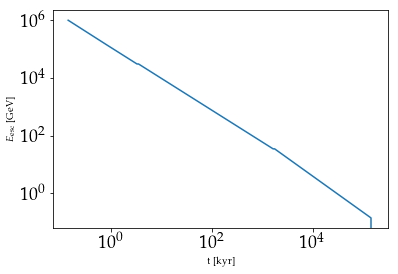

In [8]:
## Block to compute the array of escape energies during all the stages for PROTONS ##


#################
## Sedov phase ##
#################
ln_E_times_E = np.zeros(t_range_PDS_index)
E_esc_Sed_phase = np.zeros(t_range_PDS_index)


ln_E_times_E[0] = ln_E_min_escape_times_E
const_temp = ln_E_times_E[0]
res = minimize(lambda x: opt_fun(x, const_temp), x0=1.e+5)
E_esc_Sed_phase[0] = res.x[0]

for i in range(1, t_range_PDS_index):
    
    ln_E_times_E[i] = ln_E_times_E[i-1] * (t_range_release[t_range_Sed_index + i] / t_range_release[t_range_Sed_index + (i-1)])**delta_SedPDS
    
    const_temp = ln_E_times_E[i]
    res = minimize(lambda x: opt_fun(x, const_temp), x0=1.e+5)
    E_esc_Sed_phase[i] = res.x[0]



#################################
## Pressure-driven phase (PDS) ##
#################################
E_esc_PDS_phase = np.zeros(t_range_MCS_index - t_range_PDS_index)

E_esc_PDS_phase[0] = E_esc_Sed_phase[-1]
for i in range (1, t_range_MCS_index - t_range_PDS_index):
    
    E_esc_PDS_phase[i] = E_esc_PDS_phase[i-1] * (t_range_release[t_range_PDS_index + i] / t_range_release[t_range_PDS_index + (i-1)])**delta_PDSMCS



#######################################
## Momentum-conservation phase (MCS) ##
#######################################
E_esc_MCS_phase = np.zeros(t_range_merge_index - t_range_MCS_index + 1)

E_esc_MCS_phase[0] = E_esc_PDS_phase[-1]
for i in range (1, t_range_merge_index - t_range_MCS_index):
    
    E_esc_MCS_phase[i] = E_esc_MCS_phase[i-1] * (t_range_release[t_range_MCS_index + i] / t_range_release[t_range_MCS_index + (i-1)])**delta_MCSMerge



Escape_energy_vs_time = np.concatenate([E_esc_Sed_phase, E_esc_PDS_phase, E_esc_MCS_phase], axis=None)


plt.loglog(t_range_release, Escape_energy_vs_time)
plt.xlabel('t [kyr]')
plt.ylabel('$E_{\mathrm{esc}}$ [GeV]')

# <center>Propagated spectrum 

### $\bullet$ Equation $\&$ General Solution:

$$\begin{align}
&\frac{\partial f(E,t,r)}{\partial t} = \frac{D(E)}{r^2} \frac{\partial}{\partial r} r^2 \frac{\partial f}{\partial r} + \frac{\partial}{\partial E} (b(E) f) + Q \quad \Rightarrow \\[10 pt]
&\Rightarrow \quad f(r,t,E) = \frac{Q(E) }{\pi^{3/2} r^3_{\textrm{diff}}} \cdot e^{-\frac{r^2}{r^2_{\textrm{diff}}}}
\end{align}$$


### $\bullet$ Solution for decaying luminosity:

$$\begin{align}
&f(r,t_{\mathrm{age}},E) = \int_{t_{\mathrm{rel}}}^{t_{\mathrm{age}}} dt' \frac{S(E) L(t) }{\pi^{3/2} r_{\mathrm{diff}}^3(E)} \cdot e^{-\frac{r^2}{r^2_{\mathrm{diff}}}} \\[10 pt]
&r^2_{\textrm{diff}} (E) \equiv 4 D(E) \, ( t_{\mathrm{age}} - t_{\mathrm{rel}}) \\[10 pt]
&L(t) = \frac{ L_0 }{ \left(  1 + \frac{t}{\tau_{\text{d}}}  \right)^{\alpha_{\text{d}}}}
\end{align}$$

### $\bullet$ [Tomassetti, APJ vol. 752, n. 1 (2012)] ###
    
$$
\begin{align}
&\delta(\rho) \approx \delta_{\mathrm{high}} + \frac{\Delta}{1 + \frac{\xi}{1 - \xi} \left( \frac{\rho}{\rho_0} \right)^{\Delta}} \\[10 pt]
&\delta_{\mathrm{high}} = 1/6, \qquad \Delta = 0.55, \qquad \rho_0 = 2 \, \mathrm{GV}, \qquad \xi = 0.1 \\[10 pt]
&\rho = \frac{\sqrt{E_{k}^2 + 2 m_p E_{k}}}{Z}, \qquad E_{k} = \sqrt{(ZR)^2 + m_p^2} - m_p, \qquad E_{k} \equiv \mathrm{kinetic \; energy \; per \; nucleon.} 
\end{align}
$$


Minimum slope for D(E): 0.17046221519940832
Maximum slope for D(E): 0.7030041811298965



/usr/local/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


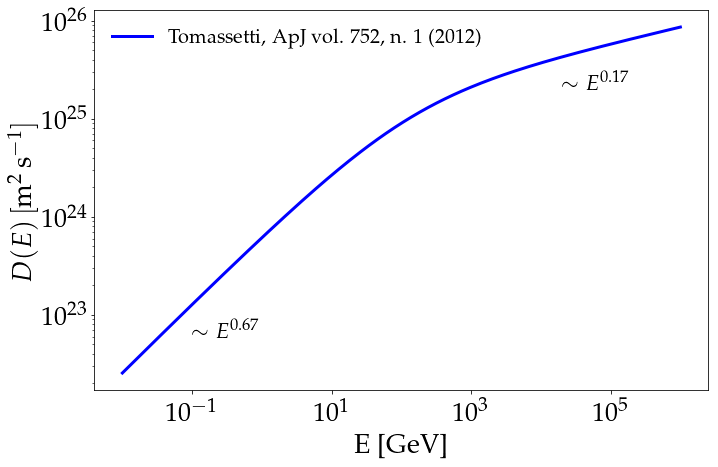

In [9]:
### Building the diffusion coefficient from Tomassetti THMb ###

rigidity_array_D = np.sqrt(E_e**2 + 2*m_p * E_e)


### Parameters to implement the variable slope from Tomassetti ###
##################################################################
ref_rigidity_tomassetti = 2.   # in [GV]
delta_HIGH_tomassetti = 1./6.
Delta_tomassetti = 0.55
csi_tomassetti = 0.1
ref_E_0 = 1.                   # in [GeV]: D(E) = D_0 (E/E_0)^delta

ref_energy_tomassetti = np.sqrt(ref_rigidity_tomassetti**2 + m_p**2) - m_p   # in [GeV]


delta_tomassetti_variable = delta_HIGH_tomassetti + Delta_tomassetti / ( 1 + ( csi_tomassetti/(1-csi_tomassetti) ) * pow( rigidity_array_D[:len(E_e)-1] / ref_rigidity_tomassetti, Delta_tomassetti) )                
print ("Minimum slope for D(E):", min(delta_tomassetti_variable))
print ("Maximum slope for D(E):", max(delta_tomassetti_variable))
print ("")

D_0_low = D_0 * (min(E_e) / ref_E_0)**(max(delta_tomassetti_variable))


D_next = np.zeros(len(E_e))
for iD in range(len(E_e)):
    if iD == 0:
        D_next[iD] = D_0_low
    else:
        D_next[iD] = D_next[iD-1] * (E_e[iD] / E_e[iD-1])**delta_tomassetti_variable[iD-1]

##################################################################


plt.figure(figsize=(11,7))


ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=26)
ax.tick_params(axis='both', which='minor', labelsize=26)
ax.xaxis.set_tick_params(pad=7)
ax.xaxis.labelpad = 7



plt.loglog(E_e, D_next, lw=3, label='Tomassetti, ApJ vol. 752, n. 1 (2012)', color='blue')
plt.text(1.e-1, 6.e+22, '$\sim E^{0.67}$', fontsize=22)
plt.text(2.e+4, 2.e+25, '$\sim E^{0.17}$', fontsize=22)
plt.legend(frameon=False, fontsize = 20)
plt.xlabel('E [GeV]', fontsize=27)
plt.ylabel('$D(E) \, \mathrm{[m^2 \, s^{-1}]}$', fontsize=27)


plt.savefig('Diffusion_coefficient_Tomassetti.pdf',format='pdf',bbox_inches='tight', dpi=200)

In [10]:
#############################
# Calculating the integrand #
#############################


################
object_age = [1.5*pow(10,5), 2.*pow(10,5), 2.5*pow(10,5)]   # age, in [yr]

gamma_inj = 2.1     
alpha_dec = 2.          
tau_dec = 1.e+5         
r_kpc = [0.35,0.35,0.35]   
N_0 = 2.e+40
Exp_cutoff = 2.3e+4
################


start = time.process_time()



steps_t_integral = 2000  # 2000, to make the high-energy wiggles disappear
int_var_length = 50

result_integrand_matrix = np.zeros( (  considered_objects,len(E_e),steps_t_integral  ) )
t_integral = np.zeros( (considered_objects, steps_t_integral) )


for i in range(considered_objects):
    
    print ("I am examining the object",object_name[i])
    r[i] = r_kpc[i]*1000*conv_factor_pc_to_m    # distance of the object, in [m]
    
    

#######################################################################################################
# given the parameters found for the specfic object, I now define the functions plotting the spectrum #
#######################################################################################################

    start_time = 1.0
    stop_time = object_age[i]*conv_factor_yr_to_sec
    t_integral[i] = np.logspace(np.log10(start_time), np.log10(stop_time), num=steps_t_integral, endpoint=True)

    
###### Section dedicated to the calculation of the integral giving the spectrum #######

## The following matrix keeps track of the different instants of life (along the columns) of the particles of a certain measured energy (in the rows) ##
    exponential_cutoff = np.zeros(len(E_e))
    numerator_no_loss_matrix = np.zeros( (  len(E_e),len(t_integral[i])  ) )
    exponential_factor_matrix = np.zeros( (  len(E_e),len(t_integral[i])  ) )
    denominator_matrix = np.zeros( (  len(E_e),len(t_integral[i])  ) )
    r_diff_square = np.zeros( (  len(E_e),len(t_integral[i])  ) )
    
    
    for e in range(len(E_e)):
        
        ## When this energy is released
        t_rel_E = t_range_release[np.argmin(abs(E_e[e] - Escape_energy_vs_time))]
        
        
        for t in range(len(t_integral[i])):
            
            numerator_no_loss_matrix[e][t] = N_0 * pow( E_e[e]/ref_E_0 , -gamma_inj ) * ( 1 / pow( 1 + t_integral[i][t]/(tau_dec*conv_factor_yr_to_sec) , alpha_dec) )   
            exponential_cutoff[e] = np.exp( - (E_e[e]*ref_E_0) / Exp_cutoff)
            r_diff_square[e][t] = 4 * D_next[e] * (object_age[i]*conv_factor_yr_to_sec - t_integral[i][t])
            exponential_factor_matrix[e][t] = np.exp( - pow( r[i], 2) / r_diff_square[e][t])
            denominator_matrix[e][t] = pow( pi * r_diff_square[e][t] , 3/2 )

            if (t_integral[i][t] >= t_rel_E*1.e+3*conv_factor_yr_to_sec):
                result_integrand_matrix[i][e][t] = (tau_dec*conv_factor_yr_to_sec) * (c/(4*pi)) * (numerator_no_loss_matrix[e][t] * exponential_factor_matrix[e][t] * exponential_cutoff[e]) / denominator_matrix[e][t]

print (time.process_time() - start, "seconds")  
                
## Now I have an integrand matrix that contains the current energy-values in the rows and the different release-times in the columns ##


I am examining the object Sample 1
I am examining the object Sample 2
I am examining the object Sample 3
12.351852999999998 seconds


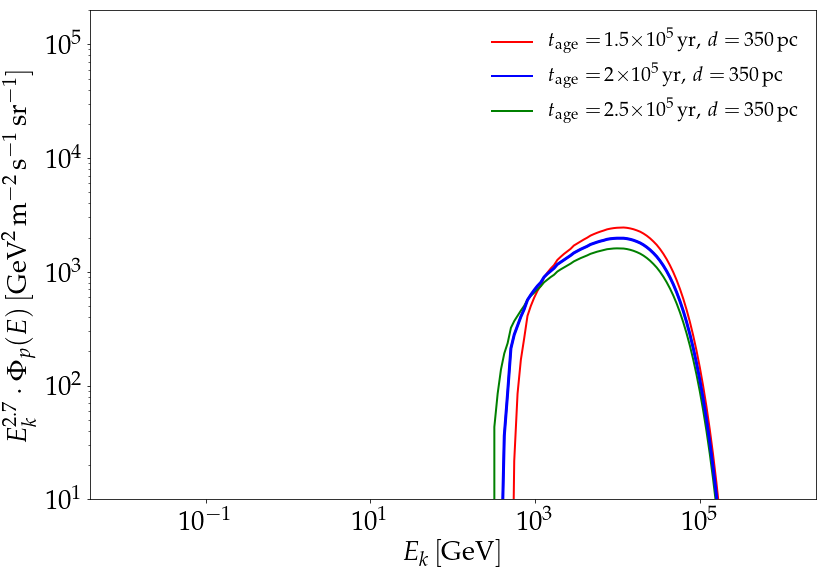

In [11]:
plt.figure(figsize=(13,9))


J_e = np.zeros( (considered_objects,len(E_e)) )  


for i in range(considered_objects):
    for e in range(len(E_e)):
        J_e[i][e] = integrate.trapz(result_integrand_matrix[i][e], t_integral[i]/(tau_dec*conv_factor_yr_to_sec))


f = mticker.ScalarFormatter(useMathText=True)
f.set_powerlimits((-5,5))
object_age_latex = []
for i in range(considered_objects):
    object_age_latex.append("${}$".format(f.format_data(object_age[i])))
    

legend_label = []
for i in range(considered_objects):
    legend_label.append( '$t_{\mathrm{age}} = \,$' + str(object_age_latex[i]) + '$\, \mathrm{yr}, \, d = \,$' + str(int(r_kpc[i]*1000)) + '$\, \mathrm{pc}$')


for i in range(considered_objects):
    plt.plot(E_e, (J_e[i])*(E_e**(2.7)), lw=2., color=multiplot_color[i], label=legend_label[i])
    
plt.plot(E_e, (J_e[1])*(E_e**(2.7)), lw=3, color='blue')


ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=27)
ax.tick_params(axis='both', which='minor', labelsize=27)
ax.xaxis.set_tick_params(pad=7)
ax.xaxis.labelpad = 7



plt.legend(fontsize = 20, loc='best', frameon=False) 

plt.ylim(1.e1, 2.e+5)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$E_{k} \, [\mathrm{GeV}]$',fontsize=27)
plt.ylabel(r'$E_{k}^{2.7} \cdot \Phi_{p}(E) \, [\mathrm{GeV}^2 \, \mathrm{m}^{-2} \, \mathrm{s}^{-1} \, \mathrm{sr}^{-1}]$',fontsize=27)


plt.savefig('Protons_DifferentAges_VariableDelta_EnDepRelease.pdf',format='pdf',bbox_inches='tight', dpi=200)


# <center>Total energy budget of the source
    
$$
\begin{align}
E_{\mathrm{tot}} &= \int d^3 \vec{r} \int^{t_{\mathrm{age}}}_{t_{\mathrm{rel}}} dt \int_0^{+ \infty} dE \, E \cdot Q(E, \vec{r}, t), \qquad \qquad \qquad Q(E, \vec{r}, t) = S_0 \left( \frac{E}{E_0} \right)^{-\Gamma_{\mathrm{inj}}} e^{-E/E_{\mathrm{cut}}} \, \delta(\vec{r}) \, L(t) \\[10 pt]
&= L_0 \, E_0^2 \, S_0 \cdot \tau_{\mathrm{d}} \int^{+ \infty}_{0} d\omega \cdot \omega^{-\Gamma_{\mathrm{inj}} + 1 } e^{-\frac{E_0}{E_{\mathrm{cut}}} \omega} \int^{t_{\mathrm{age}}}_{t_{\mathrm{rel}}(\omega)} dz \, \frac{1}{\left( 1 + z \right)^{\alpha}} \\[10 pt]
&= N_0 \cdot \tau_{\mathrm{d}} \int^{+ \infty}_{0} d\omega \cdot \omega^{-\Gamma_{\mathrm{inj}} + 1 } e^{-\frac{E_0}{E_{\mathrm{cut}}} \omega} \int^{t_{\mathrm{age}}}_{t_{\mathrm{rel}}(\omega)} dz \, \frac{1}{\left( 1 + z \right)^{\alpha}}
\end{align}
$$

In [12]:
def f_time(z):
    return pow(1 + z, - alpha_dec)


integration_var_omega = np.logspace(np.log10(1./ref_E_0), np.log10(max(E_e)/ref_E_0), num=len(E_e))
integrand_temp = np.zeros( (considered_objects,len(E_e)) )
integrand_omega = np.zeros( (considered_objects,len(E_e)) )
t_rel_E_omega = np.zeros(len(E_e))


for ic in range(considered_objects):

    for ie in range(len(E_e)):

        integrand_temp[ic][ie] = integration_var_omega[ie]**(-gamma_inj + 1) * np.exp(- (ref_E_0/Exp_cutoff) * integration_var_omega[ie])
        
        ## When this energy is released
        t_rel_E_omega[ie] = t_range_release[np.argmin(abs(E_e[ie] - Escape_energy_vs_time))]*1.e+3

        integral_time, error_time = integrate.quad(f_time, t_rel_E_omega[ie]/tau_dec, object_age[ic]/tau_dec)

        
        if (t_rel_E_omega[ie]/tau_dec < object_age[ic]/tau_dec):
            integrand_omega[ic][ie] = integrand_temp[ic][ie] * integral_time
            
    

Energy_budget_EnDepRelease = N_0 * tau_dec*conv_factor_yr_to_sec * integrate.trapz(integrand_omega, integration_var_omega)
        
    
for ic in range(considered_objects):
    print ('Energy budget in protons of object', ic, '=', Energy_budget_EnDepRelease[ic]*conv_factor_GeV_to_erg, '[erg]')


Energy budget in protons of object 0 = 1.6339247631243134e+49 [erg]
Energy budget in protons of object 1 = 2.0695035315743084e+49 [erg]
Energy budget in protons of object 2 = 2.4251652093477914e+49 [erg]
